Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


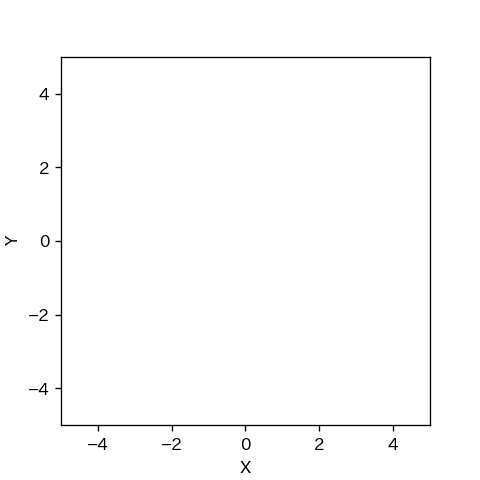

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-4.0,-2.0),np.random.uniform(-4.0,4.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


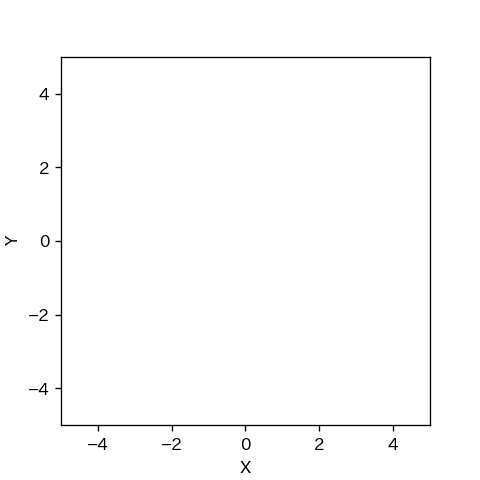

(array([-2.33235824, -1.8393928 ,  0.15513687]),
 array([-0.52464977,  4.93246639,  1.37993908]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[4.3805305738526945, 1.5785727997307866]
0 真値: [-2.71468686  1.52241895  5.69571892] 推定値: [-2.6657871   1.57181653  5.70945494] 誤差: 0.06950760942369702
1
[2.4393139879482413, 7.387593896521892]
1 真値: [-1.86446122 -2.05294112  8.12192566] 推定値: [-1.77389584 -2.40942508  1.88102354] 誤差: 0.3678082426553305
2
[0.7923489465326506, 4.849093595485194]
[0.7447160913631211, 4.098637520511041]
[3.4684327980415985, 5.003734912288054]
2 真値: [-2.38028764 -2.81541551  6.40521566] 推定値: [-2.29567053 -2.89002077  6.48718088] 誤差: 0.11280957413910349
3
[3.9742074131859364]
[5.093200574358857, 5.704097561438399]
3 真値: [-3.62759617 -2.35681773  6.97047824] 推定値: [-4.35805248 -1.74435986  0.50959206] 誤差: 0.9532423959457663
4
[6.468831681142982, 2.9512470272899844]
4 真値: [-4.89853244  2.91815544  4.50622889] 推定値: [-4.95849928  2.68460184  4.49408865] 誤差: 0.24112922852848634
5
[6.225602305832025]
[2.252492815023677, 5.280511436582016]
5 真値: [-3.30578893 -2.34931696  4.0740825 ] 推定値: [-2.97039907 -2.06184661  3.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.850782055107213]
[2.9102020039381573, 5.014834756784258]
20 真値: [-2.95841733  0.19840035  7.88412368] 推定値: [-2.90751987  0.22757259  1.58549401] 誤差: 0.058664904897785045
17
[6.513870698340692]
[1.6538145514322864, 5.163203414009105]
21 真値: [-1.24365131 -1.03349215  1.85745707] 推定値: [-1.17655613 -1.22708532  1.87314002] 誤差: 0.2048904047753436
18
[3.3361967194095783]
[2.595411794696637, 7.4208723664654075]
[2.6522559595151596, 5.867699260829826]
[2.0480690958745895, 5.5499887238018815]
22 真値: [-0.7163358   1.2988184   2.10249378] 推定値: [-0.75134098  1.43205024  2.21986968] 誤差: 0.13775371265704298
19
[4.479829961613745]
23 真値: [-4.98847785  1.85620916  6.11636002] 推定値: [-4.77115335  2.15709025  6.04400706] 誤差: 0.37115949256100766
20
[5.794933233925264]
24 真値: [-3.39254896  3.11861475  5.84307137] 推定値: [-3.45853336  3.42443763 -0.57383681] 誤差: 0.31286030744784243
21
[3.327628946745114]
[1.8241396839913862, 5.76094681581786]
25 真値: [-2.61289695 -1.14520424  7.36098211] 推定値: [-2.48084384 -